# 4. 이미지 어디까지 우려볼까?

# [GoingDeeper04] Cutmix and Mixiup Augmentation

# 0. 데이터 불러오기

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

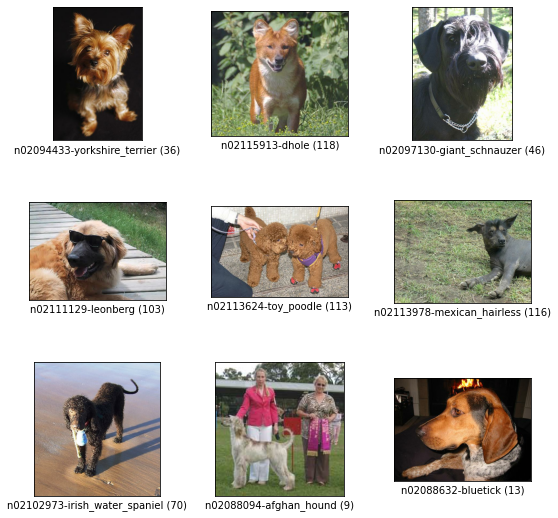

In [ ]:
fig = tfds.show_examples(ds_train, ds_info)

# **1. Augmentation을 적용한 데이터셋 만들기**

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three], axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [ ]:
# mix two labels
def mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa) * (yb-ya)
    total_area = image_size_x * image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

In [ ]:
def onehot(image, label, num_classes=120): # 이렇게만 했어요 ㅇㅁㅇ....
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size) #16 -> 1set 16*120=1920
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# **2. 모델 만들기**

In [ ]:
num_classes = ds_info.features["label"].num_classes

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [ ]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [ ]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 25
BATCH_SIZE = 16

In [ ]:
tf.random.set_seed(42)

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


# **3. 모델 훈련**

In [ ]:
%%time
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
750/750 [==============================] - 96s 116ms/step - loss: 2.1577 - accuracy: 0.4615 - val_loss: 3.6199 - val_accuracy: 0.1728
Epoch 2/25
750/750 [==============================] - 86s 114ms/step - loss: 0.6823 - accuracy: 0.8182 - val_loss: 0.9992 - val_accuracy: 0.6994
Epoch 3/25
750/750 [==============================] - 86s 115ms/step - loss: 0.1819 - accuracy: 0.9667 - val_loss: 0.9124 - val_accuracy: 0.7358
Epoch 4/25
750/750 [==============================] - 86s 114ms/step - loss: 0.0478 - accuracy: 0.9969 - val_loss: 0.8931 - val_accuracy: 0.7406
Epoch 5/25
750/750 [==============================] - 86s 115ms/step - loss: 0.0198 - accuracy: 0.9998 - val_loss: 0.9010 - val_accuracy: 0.7449
Epoch 6/25
750/750 [==============================] - 86s 115ms/step - loss: 0.0132 - accuracy: 0.9998 - val_loss: 0.9144 - val_accuracy: 0.7414
Epoch 7/25
750/750 [==============================] - 86s 114ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.9243 - val_ac

In [ ]:
history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
750/750 [==============================] - 92s 115ms/step - loss: 2.2332 - accuracy: 0.4433 - val_loss: 3.4999 - val_accuracy: 0.1833
Epoch 2/25
750/750 [==============================] - 85s 114ms/step - loss: 0.8432 - accuracy: 0.7592 - val_loss: 1.2462 - val_accuracy: 0.6412
Epoch 3/25
750/750 [==============================] - 85s 114ms/step - loss: 0.3881 - accuracy: 0.8974 - val_loss: 0.9871 - val_accuracy: 0.7099
Epoch 4/25
750/750 [==============================] - 91s 121ms/step - loss: 0.1809 - accuracy: 0.9630 - val_loss: 0.9662 - val_accuracy: 0.7185
Epoch 5/25
750/750 [==============================] - 86s 114ms/step - loss: 0.0937 - accuracy: 0.9868 - val_loss: 1.0513 - val_accuracy: 0.7050
Epoch 6/25
750/750 [==============================] - 86s 115ms/step - loss: 0.0482 - accuracy: 0.9947 - val_loss: 0.9284 - val_accuracy: 0.7406
Epoch 7/25
750/750 [==============================] - 86s 115ms/step - loss: 0.0296 - accuracy: 0.9967 - val_loss: 0.9762 - val_ac

In [ ]:
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
750/750 [==============================] - 95s 118ms/step - loss: 3.8327 - accuracy: 0.2135 - val_loss: 3.6041 - val_accuracy: 0.1725
Epoch 2/25
750/750 [==============================] - 87s 116ms/step - loss: 2.9362 - accuracy: 0.4297 - val_loss: 1.3789 - val_accuracy: 0.6243
Epoch 3/25
750/750 [==============================] - 87s 116ms/step - loss: 2.6061 - accuracy: 0.5434 - val_loss: 1.1944 - val_accuracy: 0.6728
Epoch 4/25
750/750 [==============================] - 87s 117ms/step - loss: 2.4106 - accuracy: 0.6053 - val_loss: 1.0988 - val_accuracy: 0.6880
Epoch 5/25
750/750 [==============================] - 87s 117ms/step - loss: 2.2710 - accuracy: 0.6555 - val_loss: 1.1964 - val_accuracy: 0.6730
Epoch 6/25
750/750 [==============================] - 88s 117ms/step - loss: 2.1408 - accuracy: 0.6923 - val_loss: 1.3820 - val_accuracy: 0.6264
Epoch 7/25
750/750 [==============================] - 87s 117ms/step - loss: 2.0571 - accuracy: 0.7179 - val_loss: 1.3624 - val_ac

In [ ]:
history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/25
750/750 [==============================] - 95s 118ms/step - loss: 3.7591 - accuracy: 0.2304 - val_loss: 4.0099 - val_accuracy: 0.1156
Epoch 2/25
750/750 [==============================] - 87s 116ms/step - loss: 2.8820 - accuracy: 0.4791 - val_loss: 1.6484 - val_accuracy: 0.5612
Epoch 3/25
750/750 [==============================] - 88s 117ms/step - loss: 2.5630 - accuracy: 0.5909 - val_loss: 1.3656 - val_accuracy: 0.6135
Epoch 4/25
750/750 [==============================] - 88s 117ms/step - loss: 2.3980 - accuracy: 0.6600 - val_loss: 1.4301 - val_accuracy: 0.6114
Epoch 5/25
750/750 [==============================] - 88s 117ms/step - loss: 2.2525 - accuracy: 0.7123 - val_loss: 1.2413 - val_accuracy: 0.6674
Epoch 6/25
750/750 [==============================] - 88s 117ms/step - loss: 2.1520 - accuracy: 0.7470 - val_loss: 1.2747 - val_accuracy: 0.6503
Epoch 7/25
750/750 [==============================] - 88s 117ms/step - loss: 2.0503 - accuracy: 0.7857 - val_loss: 1.2789 - val_ac

# **4. 훈련 과정 시각화**

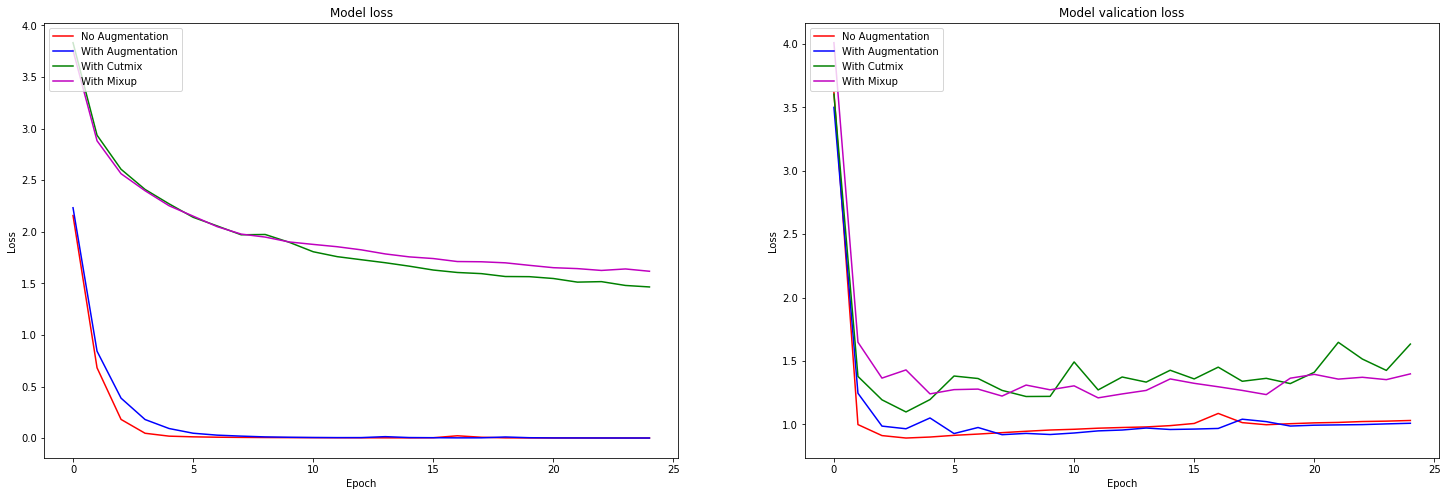

In [ ]:
fig = plt.figure(figsize=(25,8))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_cutmix.history['loss'], 'g')
plt.plot(history_resnet50_mixup.history['loss'], 'm')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'm')
plt.title('Model valication loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.show()

# **5. Augmentation에 의한 모델 성능 비교**

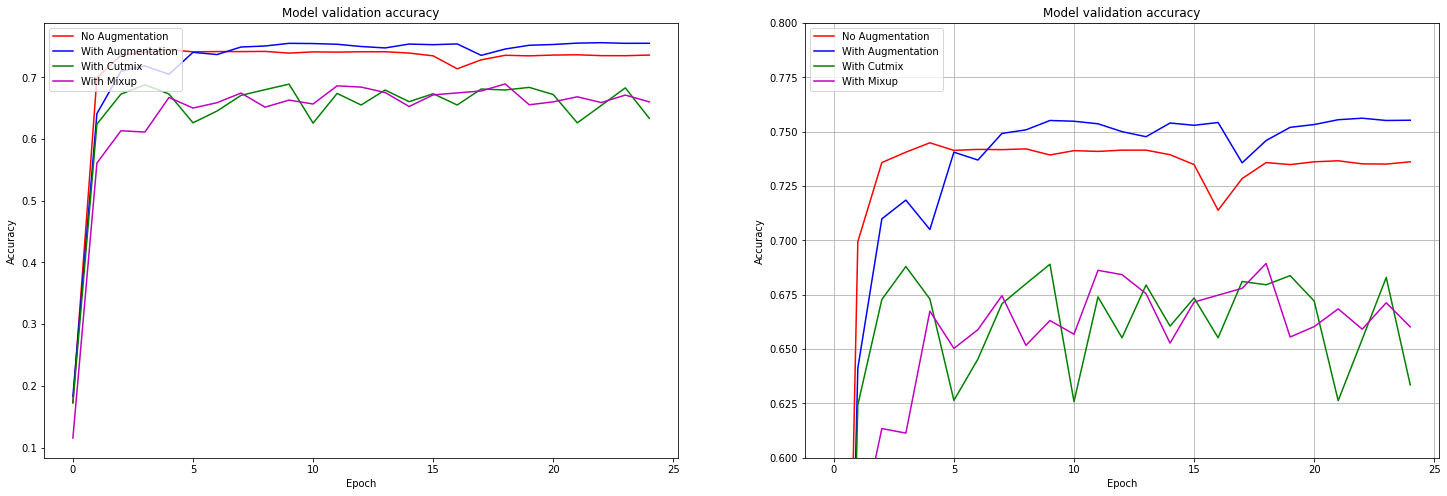

In [ ]:
fig = plt.figure(figsize=(25,8))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.60, 0.80)
plt.show()

# 프로젝트 정리
* Augmentation의 다양한 기법들을 배우는 시간이었다.
* Cutmix, MIxup을 사용했지만, augmentation을 적용하지 않은것 보다 성능이 좋지않았다.
* 좌우반전 augmentation만 적용한 것이 의외로 가장 좋았다.
* Cutmix, Mixup보다 기본 augmentation의 방법론들을 더 세밀하게 공부해서 적용하는 것이 더 좋을 것 같다.